# Multi-planet Fits #

by Jason Wang (2020)

In `orbitize!`, we can fit for multiple planets in the system in the same way as fitting a single planet. Note that currently, `orbitize!` handles planet-planet gravitational interations with an nbody integrator solver. However, here, we only take into account star-planet interactions. For example, the distance between planet b and the star will change with the existance of planet c because planet c has some finite mass and perturbs the star from the system barycenter. Even without planet-planet scattering, one can approximately fit for dynamical masses this way. By default in `orbitize!`, we assume the planets are test particles (mass = 0), so there is no star-planet interactions. Later in this tutorial in the "Multiplanet Dynamical Mass" section, we will describe how to turn on this feature. 

Multi-planet capabilities are generally handled under the hood, requiring not many modifications to the procedure for fitting a single planet. In this example, we will fit a few measurements of the HR 8799 b and c planets.


In [1]:
import os
import orbitize
import orbitize.driver

In this tutorial, we will do an example with OFTI just because it is fast. However, in most cases, you will likely want to use MCMC as OFTI slows down significantly with multiple planets (even if each planet only has two astrometric data points as shown in the example). MCMC also requires longer run time typically, but it generally scales better than OFTI.

We follow the same steps as in the [OFTI tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/OFTI_tutorial.html) but set number of secondary bodies to 2 and read in a data file that contains astrometry for two planets in the system (in the example, a shortened version of the HR 8799 b and c astrometry). For MCMC, do the same thing as the single planet [MCMC tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html) and make the same challenges as we have here with OFTI. In summary, all that needs to be done is to include both planets' measurements in the input data file and adjust the number of secondary bodies in the system. 


In [2]:
input_file = os.path.join(orbitize.DATADIR, "test_val_multi.csv")
my_driver = orbitize.driver.Driver(input_file, 'OFTI',
                                      2, # number of secondary bodies in system
                                      1.52, # total mass [M_sun]
                                      24.76, # total parallax of system [mas]
                                      mass_err=0.15, 
                                      plx_err=0.64)

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.


Next we run the sampler as usual:

In [3]:
s = my_driver.sampler
orbits = s.run_sampler(1000)

With two planets, we have 2 sets of 6 orbtial parameters as well as the 2 system parameters (parallax and total mass). Our posterior, stored in `orbits`, is a (1000 x 14) array instead of the (1000 x 8) array had we fit a single planet. 

As it gets confusing to track with index corresponds to which orbital parameter, we recommend you use the system.param_idx to index the parameters you are interested in. As a reminder, the abbreviations are: semi-major axis (sma), eccentricity (ecc), inclination (inc), argument of periastron (aop), position angle of nodes (pan), and epoch of periastron passage in fraction of the orbital period (tau). The 1 and 2 correspond to the two secondary bodies (in this case, HR 8799 b and HR 8799 c respectively)

In [4]:
print(orbits[0])
print(orbits.shape)
print(s.system.param_idx)

[56.24156344  0.27898557  0.30103121  1.9027183   2.28889823  0.46425206
 66.25721525  0.58545346  1.68028001  4.79289978  2.23970056  0.33901155
 24.8454356   1.43000678]
(1000, 14)
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'mtot': 13}


## Plotting ##

We will go over briefly some considerations for visualizing multiplanet fits using the `orbitize!` API. For a more detailed guide on data visualization capabilities within orbitize, see the [Orbitize plotting tutorial](https://orbitize.info/en/latest/tutorials/Plotting_tutorial.html).

### Corner Plot ###

Corner plots are slow when trying to plot too many parameters (the number of subplots scales as n^2 where n is the number of dimensions). It also is difficult to read a plot with too many subplots. For this reason, we recommend looking at particular parameter covariances, or breaking it up to have one corner plot for each planet. Again, use the notation in `system.param_idx` notation to grab the parameters you want.

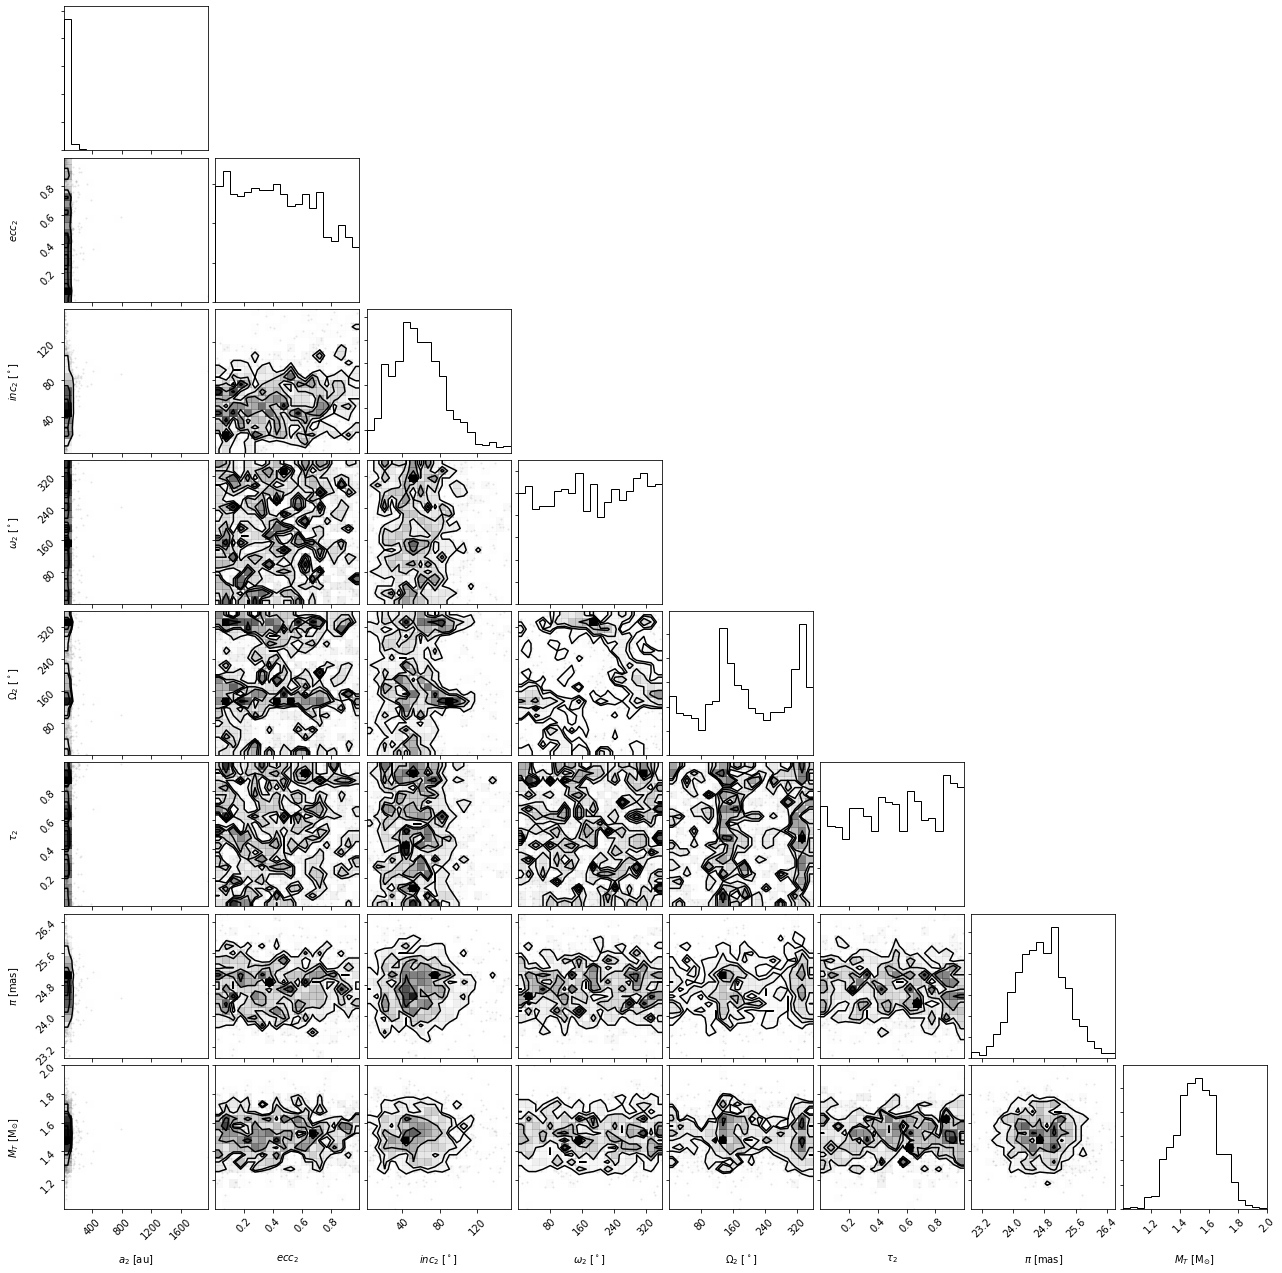

In [5]:
my_results = s.results
corner_figure = my_results.plot_corner(param_list=['sma2', 'ecc2', 'inc2', 'aop2', 'pan2','tau2', 'plx', 'mtot'])

### Orbit Plot ###

Currently, the orbit plotting tool in results class only plots the orbit of one body at a time. You can select which body you wish to plot.

<Figure size 1008x432 with 0 Axes>

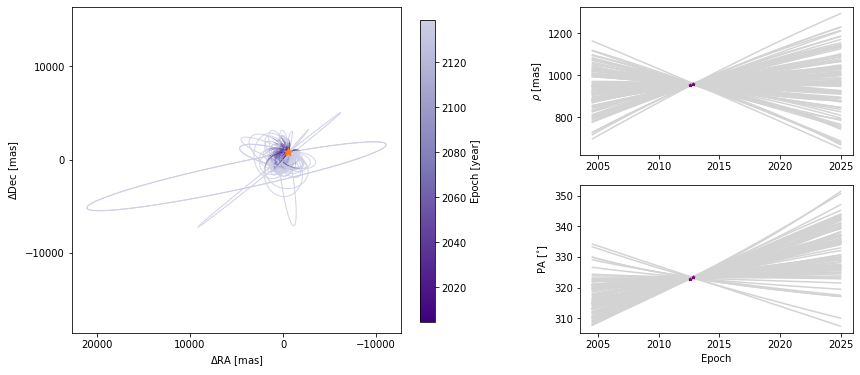

In [6]:
epochs = my_driver.system.data_table['epoch']

orbit_figure = my_results.plot_orbits(
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch),
    object_to_plot=2 # plot planet c
)

<Figure size 1008x432 with 0 Axes>

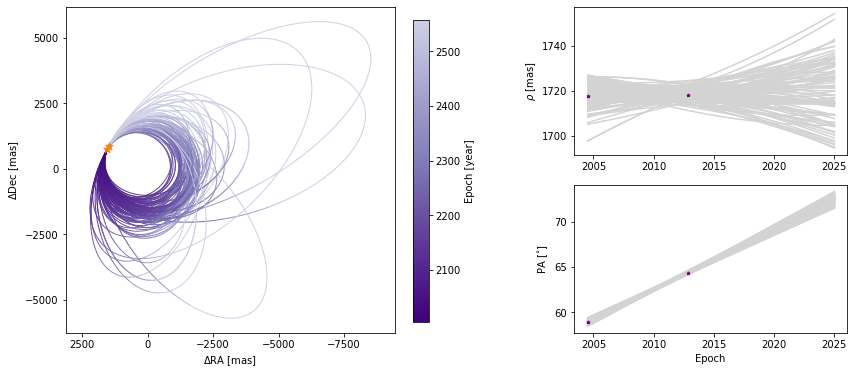

In [7]:
orbit_figure = my_results.plot_orbits(
    start_mjd=epochs[0], # Minimum MJD for colorbar (here we choose first data epoch),
    object_to_plot=1 # plot planet b
)

## Multiplanet Dynamical Mass ##

In the case we want to fit dynamical masses, the procedure again remains unchanged as for a single planet system (as described in the [RV MCMC Tutorial](RV_MCMC_Tutorial.html)). The only thing to be aware of the extra parameters for the indiviudal masses of the components. Again, use the `system.param_idx` dictionary to keep track of the indices instead of trying to keep track of the ordering in one's head. Here, we will not demo a fit, but just show the increasing of parameters by 2 when fitting for the masses of the two secondary bodies.

Here, the new parameters are `m1` and `m2`, the masses of planets b and c. `m0` remains the mass of the star.

In [8]:
input_file = os.path.join(orbitize.DATADIR, "test_val_multi.csv")
my_driver = orbitize.driver.Driver(input_file, 'MCMC',
                                      2, # number of secondary bodies in system
                                      1.52, # stellar mass [M_sun]
                                      24.76, # total parallax of system [mas]
                                      mass_err=0.15, 
                                      plx_err=0.64,
                                      system_kwargs={'fit_secondary_mass' : True })
print(my_driver.system.param_idx)
print(len(my_driver.system.sys_priors))

{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'm1': 13, 'm2': 14, 'm0': 15}
16
